In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
import random
from collections import defaultdict
from gensim.models import Word2Vec

class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1.0, q=3.0):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q

    def generate_walks(self):
        walks = []
        nodes = list(self.graph.nodes())

        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(node))

        return walks

    def node2vec_walk(self, start_node):
        walk = [start_node]

        while len(walk) < self.walk_length:
            current_node = walk[-1]
            neighbors = list(self.graph.neighbors(current_node))

            if len(neighbors) > 0:
                if len(walk) == 1:
                    walk.append(random.choice(neighbors))
                else:
                    prev_node = walk[-2]
                    next_node = self.get_next_node(prev_node, current_node, neighbors)
                    walk.append(next_node)
            else:
                break

        return walk

    def get_next_node(self, prev_node, current_node, neighbors):
        edge_weights = defaultdict(dict)

        for neighbor in neighbors:
            if neighbor == prev_node:
                edge_weights[neighbor]['weight'] = 1.0 / self.p
            elif self.graph.has_edge(neighbor, prev_node):
                edge_weights[neighbor]['weight'] = 1.0
            else:
                edge_weights[neighbor]['weight'] = 1.0 / self.q

        total_weight = sum(edge_weights[neighbor]['weight'] for neighbor in neighbors)
        normalized_weights = [(neighbor, edge_weights[neighbor]['weight'] / total_weight) for neighbor in neighbors]
        next_node = self.weighted_random_choice(normalized_weights)

        return next_node

    def weighted_random_choice(self, choices):
        population, weights = zip(*choices)
        return random.choices(population, weights=weights)[0]

    def fit(self, window_size=5, min_count=1, batch_words=4):
        walks = self.generate_walks()
        model = Word2Vec(walks, vector_size=self.dimensions, window=window_size, min_count=min_count, sg=1, workers=4, batch_words=batch_words)
        return model

#Preprocess the Data
data = pd.read_csv('/content/drive/MyDrive/Payments-Node2Vec.csv')

#Construct a Graph
G = nx.DiGraph()
for _, row in data.iterrows():
    sender = str(row['Sender'])
    receiver = str(row['Receiver'])
    amount = row['Amount']
    G.add_edge(sender, receiver, weight=amount)

#Generate Node Embeddings with Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200)
model = node2vec.fit(window_size=10, min_count=1, batch_words=4)
embeddings = model.wv.vectors

scaler = StandardScaler()
scaled_embedding = scaler.fit_transform(embeddings)

#Clustering with K-means
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(scaled_embedding)

#Identify potential fraudulent payments
fraudulent_transactions = []
for i, label in enumerate(labels):
    if label == 1:  # Assuming cluster with label 1 represents fraudulent transactions
        node_id = model.wv.index_to_key[i]
        fraudulent_transactions.append(node_id)

#Print the potential fraudulent transactions and the total count
print("Potential Fraudulent Transactions:")
for transaction in fraudulent_transactions:
    print(transaction)

total_fraudulent = len(fraudulent_transactions)
print(f"\nTotal Fraudulent Transactions: {total_fraudulent}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Potential Fraudulent Transactions:
1318
1376
1249
1226
1385
1325
1205
1086
1042
1210
1626
1258
1530
1005
1057
1048
1312
1498
1549
1225
1410
1018
1434
1288
1058
1464
1813
1544
1609
1252
1398
1207
1227
1777
1295
1102
1521
1423
1022
1167
1420
1588
1383
1515
1466
1975
1942
1935
1763
1978
1441
2170
1453
2093
1635
1525
1933
1332
1735
1481
1195
1804
1045
1731
2025
1115
1554
1313
1558
1165
1822
1395
1949
1634
1689
1357
1614
1752
1870
1863
1970
1873
1176
1203
1543
1585
1425
2021
1451
1879
1725
1303
1460
1372
1596
1980
1462
1572
1495
1717
1304
1901
1710
1571
1216
1669
1798
1485
2052
1899
1444
1616
1673
1047
1821
1576
1644
1437
1877

Total Fraudulent Transactions: 119


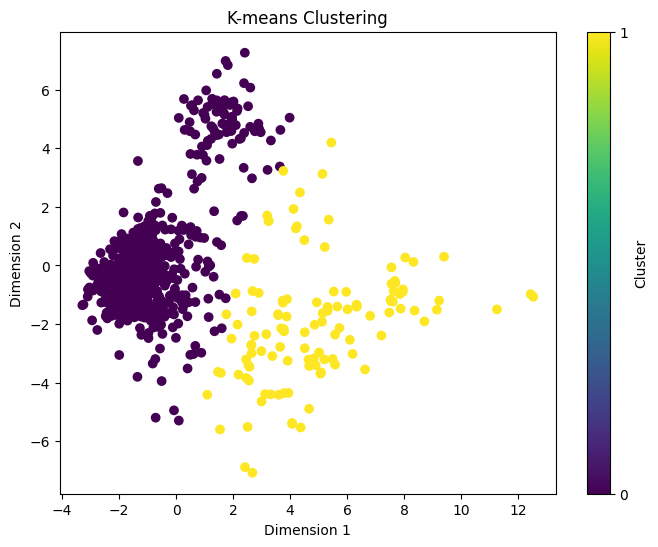

In [ ]:
import matplotlib.pyplot as plt


pca = PCA(n_components=2)  # Reduce to 2-dimensional space for visualization
reduced_embeddings = pca.fit_transform(scaled_embedding)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('K-means Clustering')
plt.colorbar(ticks=[0, 1], label='Cluster')
plt.show()

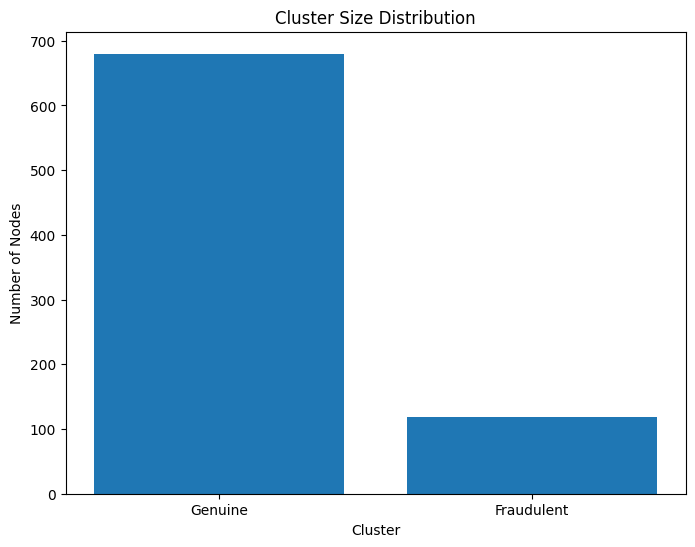

In [ ]:
# Count the number of nodes in each cluster
cluster_sizes = np.bincount(labels)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes)
plt.xlabel('Cluster')
plt.ylabel('Number of Nodes')
plt.title('Cluster Size Distribution')
plt.xticks(range(len(cluster_sizes)), ['Genuine', 'Fraudulent'])
plt.show()

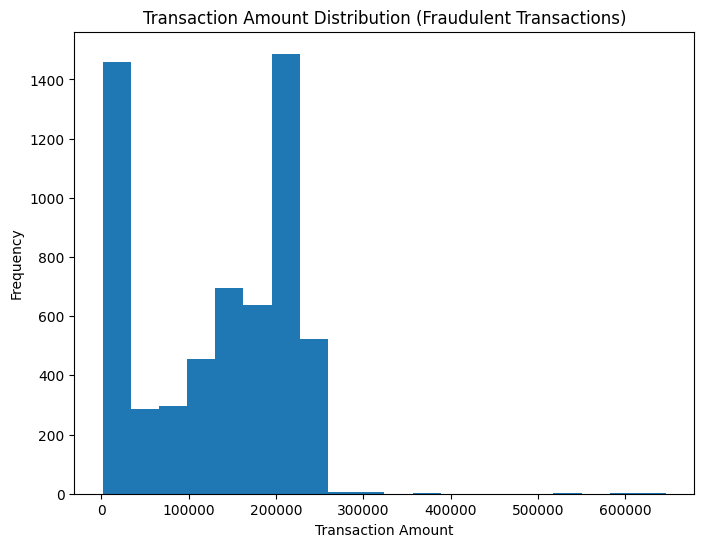

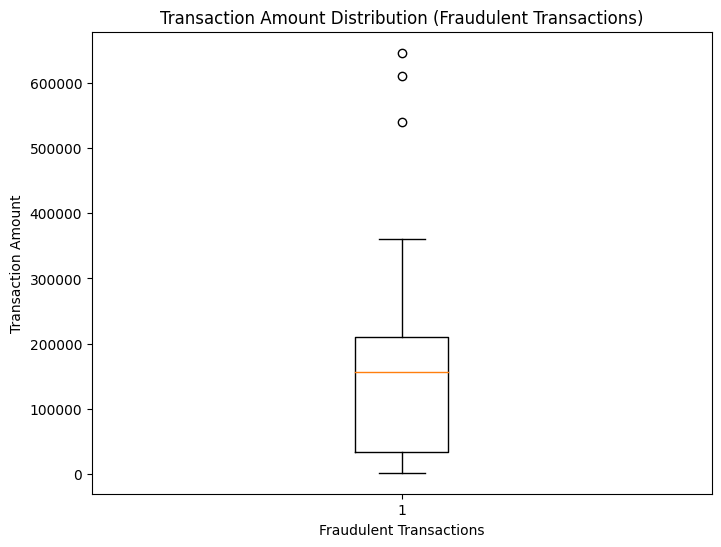

In [ ]:
fraudulent_amounts = []
for transaction in fraudulent_transactions:
    amounts = data.loc[data['Sender'].astype(str) == transaction, 'Amount']
    fraudulent_amounts.extend(amounts)

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(fraudulent_amounts, bins=20)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Transaction Amount Distribution (Fraudulent Transactions)')
plt.show()

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(fraudulent_amounts)
plt.xlabel('Fraudulent Transactions')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount Distribution (Fraudulent Transactions)')
plt.show()